# Imports

In [1]:
import tensorflow as tf
# from tensorflow.python.framework.ops import disable_eager_execution 
# disable_eager_execution()
# from tensorflow.python.framework.ops import enable_eager_execution
# enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Import common tensorflow layers and activations
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import Lambda, Multiply, Add, Rescaling
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input

from tabnet import TabNet

# Data Defn

In [3]:
BATCH_SIZE = 16384

# Load telematics data
telematics = pd.read_csv("./telematics_syn-032021.csv")
outputs = ['NB_Claim', 'AMT_Claim']
response = 'Risky_driver'
telematics[response] = ((telematics['NB_Claim'] > 0) & (telematics['AMT_Claim'] > 1000)).astype(float)
telematics.drop([x for x in outputs if x != response], axis=1, inplace=True)

# Split data into train and test
data_train, data_test = train_test_split(telematics, test_size=0.3, random_state=42)
data_val, data_test = train_test_split(data_test, test_size=0.33, random_state=42)

# Mean target encode categorical variables
aggregate_fn = np.mean
for col in ['Marital', 'Insured.sex', 'Car.use', 'Region', 'Territory']:
    encoding = data_train.groupby(col)[response].aggregate(aggregate_fn)
    data_train[col] = data_train[col].map(encoding)
    data_val[col] = data_val[col].map(encoding)
    data_test[col] = data_test[col].map(encoding)

# Split into X and y
X_train = data_train.drop(response, axis=1, errors='ignore')
y_train = data_train[response]
X_val = data_val.drop(response, axis=1, errors='ignore')
y_val = data_val[response]
X_test = data_test.drop(response, axis=1, errors='ignore')
y_test = data_test[response]

# Make tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values[..., np.newaxis]))
train_dataset = train_dataset.shuffle(buffer_size=4048).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values[..., np.newaxis]))
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values[..., np.newaxis]))
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-05-03 14:48:31.343150: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-03 14:48:31.343223: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (al3615): /proc/driver/nvidia/version does not exist
2023-05-03 14:48:31.344345: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Confirm stats line up with paper
telematics[response].sum(), (1-telematics[response]).sum(), X_train.shape, telematics.shape

(2698.0, 97302.0, (70000, 50), (100000, 51))

In [5]:
test_dataset.element_spec

(TensorSpec(shape=(None, 50), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))

# Model creation and training

In [6]:
tabnet = TabNet(dim_features=X_train.shape[1], dim_attention=64, dim_output=1, output_activation="sigmoid")

tabnet.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.AUC(from_logits=False, name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
        ]
)
tabnet.build(X_train.sample(1).shape)

In [7]:
dummy_true = tf.ones(shape=(7,1))
dummy_input = tf.random.normal((7, X_train.shape[1]))
dummy_pred = tabnet(dummy_input)[0]
tf.keras.losses.BinaryCrossentropy(from_logits=True)(dummy_true, dummy_pred), dummy_pred.shape, dummy_true.shape

/home/alexander/projects/deep_learning_vs_gbdt/venv/lib/python3.9/site-packages/keras/backend.py:5004: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


(<tf.Tensor: shape=(), dtype=float32, numpy=0.69532824>,
 TensorShape([7, 1]),
 TensorShape([7, 1]))

In [8]:
tabnet.summary()

Model: "tab_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_feature_layer (Shared multiple                  90112     
_________________________________________________________________
feat_0 (FeatureTransformer)  multiple                  190208    
_________________________________________________________________
feat_1 (FeatureTransformer)  multiple                  190208    
_________________________________________________________________
feat_2 (FeatureTransformer)  multiple                  190208    
_________________________________________________________________
feat_3 (FeatureTransformer)  multiple                  190208    
_________________________________________________________________
feat_4 (FeatureTransformer)  multiple                  190208    
_________________________________________________________________
feat_5 (FeatureTransformer)  multiple                  1902

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor="val_recall")
lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
history = tabnet.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[early_stopping, lr_on_plateau])

Epoch 1/1000


2023-05-03 14:48:40.860407: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


5/5 [==============================] - 21s 2s/step - loss: 0.3221 - auc: 0.5240 - binary_accuracy: 0.8218 - precision: 0.0289 - recall: 0.1721 - val_loss: 0.3772 - val_auc: 0.3678 - val_binary_accuracy: 0.9734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
1/5 [=====>........................] - ETA: 8s - loss: 0.1436 - auc: 0.5711 - binary_accuracy: 0.9733 - precision: 1.0000 - recall: 0.0023

KeyboardInterrupt: 

In [ ]:
tabnet.history.history.keys()

dict_keys(['loss', 'auc', 'binary_accuracy', 'precision', 'recall', 'val_loss', 'val_auc', 'val_binary_accuracy', 'val_precision', 'val_recall', 'lr'])

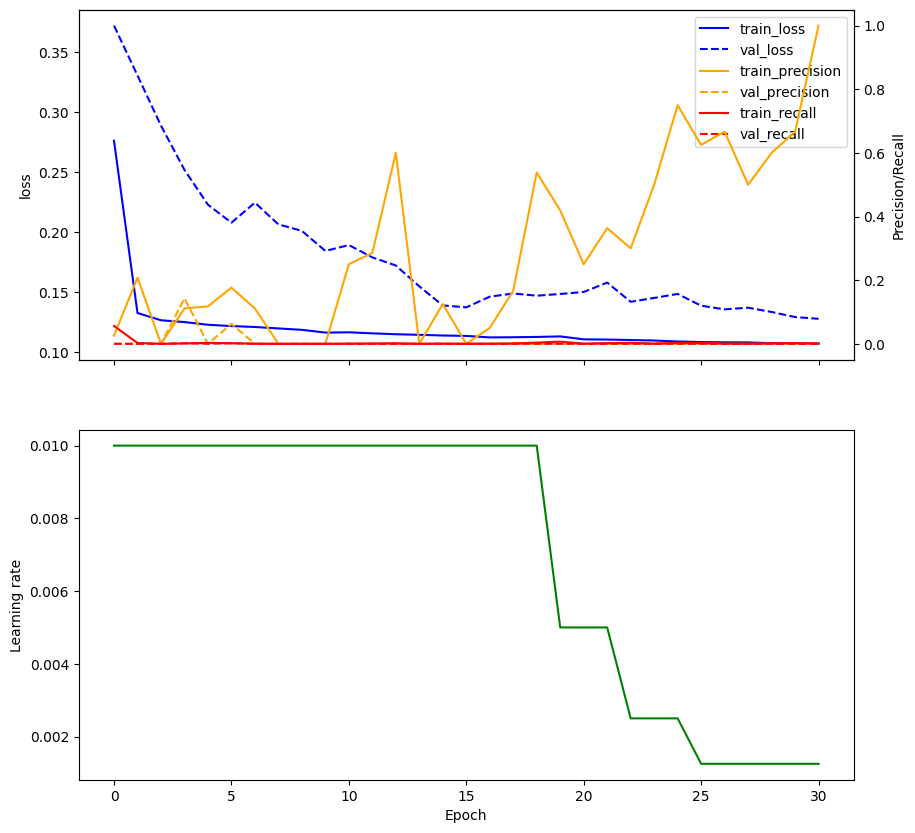

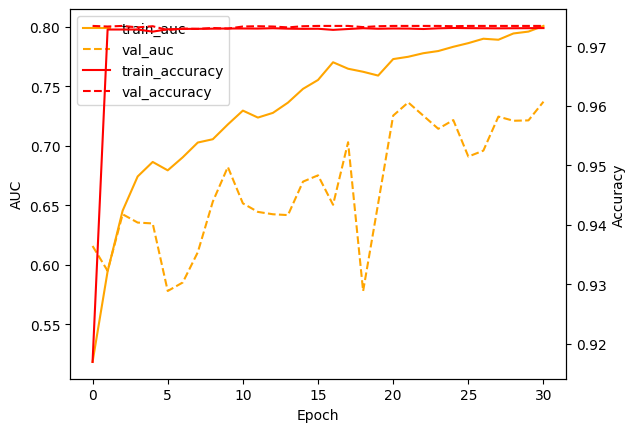

In [ ]:
# Plot history loss and RMSE for training and validation set; train solid line, validation dashed line
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

hist = tabnet.history.history

top_ax.plot(hist['loss'], label='train_loss', c='b')
top_ax.plot(hist['val_loss'], label='val_loss', linestyle='--', c='b')
second_ax = top_ax.twinx()
# Plot precision and recall on second axis in orange and red respectively
second_ax.plot(hist['precision'], label='train_precision', c='orange')
second_ax.plot(hist['val_precision'], label='val_precision', linestyle='--', c='orange')
second_ax.plot(hist['recall'], label='train_recall', c='r')
second_ax.plot(hist['val_recall'], label='val_recall', linestyle='--', c='r')
top_ax.set_ylabel('loss')
second_ax.set_ylabel('Precision/Recall')
# Merge top ax legend entries
handles, labels = top_ax.get_legend_handles_labels()
handles2, labels2 = second_ax.get_legend_handles_labels()
top_ax.legend(handles + handles2, labels + labels2)


bottom_ax.plot(hist['lr'], label='lr', c='g')
bottom_ax.set_xlabel('Epoch')
bottom_ax.set_ylabel('Learning rate')

# New plot with auc and accuracy
fig, ax = plt.subplots()
ax.plot(hist['auc'], label='train_auc', c='orange')
ax.plot(hist['val_auc'], label='val_auc', linestyle='--', c='orange')
twinax = ax.twinx()
twinax.plot(hist['binary_accuracy'], label='train_accuracy', c='r')
twinax.plot(hist['val_binary_accuracy'], label='val_accuracy', linestyle='--', c='r')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
twinax.set_ylabel('Accuracy')
# Merge legend entries
handles, labels = ax.get_legend_handles_labels()
twinhandles, twinlabels = twinax.get_legend_handles_labels()
ax.legend(handles + twinhandles, labels + twinlabels)




In [ ]:
# Evaluate model on test set
tabnet.evaluate(test_dataset)

1/1 [==============================] - 0s 304ms/step - loss: 0.3717 - auc: 0.6142 - binary_accuracy: 0.9721 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.37167155742645264, 0.6142217516899109, 0.9721212387084961, 0.0, 0.0]